In [35]:
import numpy as np
import pkg_resources

from ev2gym_driveway.models.ev2gym_driveway_env import EV2GymDriveway
from ev2gym_driveway.rl_agent.state import state_function_basic_profit_view
from ev2gym_driveway.rl_agent.reward import reward_function_profit_only

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from itertools import count

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [36]:
# we will use an example configuration file
config_file = "/example_config_files/3_houses_no_inflexible_loads.yaml"
config_file = pkg_resources.resource_filename('ev2gym_driveway', config_file)

env = EV2GymDriveway(config_file, seed=42, state_function=state_function_basic_profit_view,
        reward_function=reward_function_profit_only, save_statistics=True)




In [37]:
# Example: Make your own discretization of the action space
def discretize_action(action):
    if 0 <= action and action < 41**3:
        ev0 = action // 41**2
        ev1 = (action % 41**2) // 41
        ev2 = action % 41
        return [-1.0 + 0.05 * ev0, -1.0 + 0.05 * ev1, -1.0 + 0.05 * ev2]
    else:
        raise ValueError("Invalid action: ", action)    
    
n_actions = 41**3

In [38]:
def reward_function(env,*args):
    
    reward = reward_function_profit_only(env, None, None, None)
    
    return reward

In [39]:
class Qnetwork(nn.Module):
             
    def __init__(self, n_observations, n_actions):
        super(Qnetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [40]:
# Get the number of state observations
state,_ = env.reset()
n_observations = len(state)

policy_net = Qnetwork(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load("policy_net0.pt", weights_only=True))
policy_net.eval()

target_net = Qnetwork(n_observations, n_actions).to(device)
target_net.load_state_dict(torch.load("target_net0.pt", weights_only=True))
target_net.eval()

Qnetwork(
  (layer1): Linear(in_features=15, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=68921, bias=True)
)

In [41]:
def select_action(state):
    with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return policy_net(state).max(1).indices.view(1, 1)

In [42]:
env.set_reward_function(reward_function)

# Like Training, but run only one episode for testing

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
episode_reward = 0
for t in count():
    action = select_action(state)

    observation, reward, done, truncated, stats = env.step(discretize_action(action.item()))
    episode_reward += reward
    #reward = torch.tensor([reward], dtype=torch.float32, device=device)  

    if done:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    state = next_state

    if done:
        break

print(episode_reward)
print(stats)


EV 0 arrived from trip at 2022-01-17 13:00:00. Drove: 70.48989216904906 km.
EV 0 used 11.63 kWh of energy during the trip.
Energy Before Trip: 77.00 kWh
Energy After Trip: 65.37 kWh
EV 0 arrived from trip at 2022-01-17 14:45:00. Drove: 65.30979778744563 km.
EV 0 used 10.84 kWh of energy during the trip.
Energy Before Trip: 58.00 kWh
Energy After Trip: 47.16 kWh
EV 0 arrived from trip at 2022-01-17 18:00:00. Drove: 6.782432902423866 km.
EV 0 used 0.93 kWh of energy during the trip.
Energy Before Trip: 10.00 kWh
Energy After Trip: 9.07 kWh
EV 0 arrived from trip at 2022-01-18 09:15:00. Drove: 8.956892293349908 km.
EV 0 used 1.48 kWh of energy during the trip.
Energy Before Trip: 77.00 kWh
Energy After Trip: 75.52 kWh
EV 0 arrived from trip at 2022-01-18 12:30:00. Drove: 17.440684636420134 km.
EV 0 used 2.39 kWh of energy during the trip.
Energy Before Trip: 10.00 kWh
Energy After Trip: 7.61 kWh
EV 0 arrived from trip at 2022-01-18 13:30:00. Drove: 1.5993378868862687 km.
EV 0 used 0.27 kW

In [44]:
# Load in statistics
import pickle
from dataclasses import fields
import matplotlib.pyplot as plt
import numpy as np

def load_stats(file_name: str):
    with open(file_name, "rb") as f:
        loaded_stats = pickle.load(f)

    for field in fields(loaded_stats):
        name = field.name
        value = getattr(loaded_stats, name)
        print(f"{name}: {value.shape}")
    
    return loaded_stats

In [46]:
CAFAP_Stats = load_stats("statistics/3_houses_no_inflexible_loads_CAFAP.pkl")

DQN_Stats = load_stats("statistics/3_houses_no_inflexible_loads_DQN.pkl")

cs_power_usage: (3, 672)
cs_current: (3, 672)
tr_inflexible_loads: (1, 672)
tr_overload: (1, 672)
money_spent_at_each_step: (3, 672)
money_earned_at_each_step: (3, 672)
cs_power_usage: (3, 672)
cs_current: (3, 672)
tr_inflexible_loads: (1, 672)
tr_overload: (1, 672)
money_spent_at_each_step: (3, 672)
money_earned_at_each_step: (3, 672)


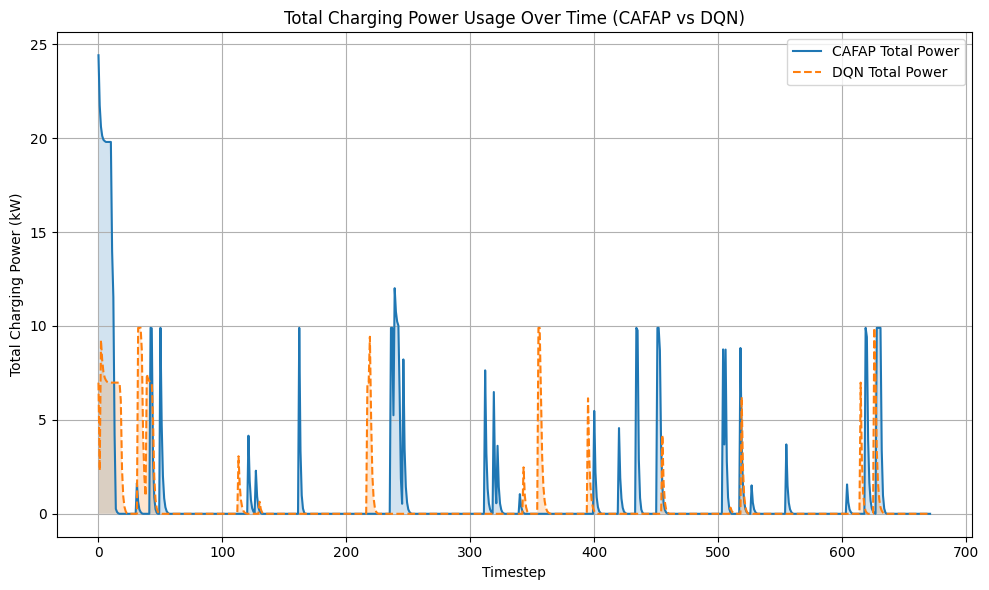

CAFAP Std Dev: 3.28510343860949
DQN Std Dev: 1.8292081413224364
CAFAP Peak-to-Average Ratio: 25.52168798015548
DQN Peak-to-Average Ratio: 18.32367723175868


In [49]:
import matplotlib.pyplot as plt
import numpy as np

timesteps = np.arange(CAFAP_Stats.cs_power_usage.shape[1])

# Sum across the EVs to get total charging power
CAFAP_total_power = np.sum(CAFAP_Stats.cs_power_usage, axis=0)
DQN_total_power = np.sum(DQN_Stats.cs_power_usage, axis=0)

plt.figure(figsize=(10,6))

plt.plot(timesteps, CAFAP_total_power, label="CAFAP Total Power", linestyle="-")
plt.plot(timesteps, DQN_total_power, label="DQN Total Power", linestyle="--")

plt.xlabel("Timestep")
plt.ylabel("Total Charging Power (kW)")
plt.title("Total Charging Power Usage Over Time (CAFAP vs DQN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.fill_between(timesteps, CAFAP_total_power, alpha=0.2)
plt.fill_between(timesteps, DQN_total_power, alpha=0.2)
plt.show()

print("CAFAP Std Dev:", np.std(CAFAP_total_power))
print("DQN Std Dev:", np.std(DQN_total_power))

print("CAFAP Peak-to-Average Ratio:", np.max(CAFAP_total_power)/np.mean(CAFAP_total_power))
print("DQN Peak-to-Average Ratio:", np.max(DQN_total_power)/np.mean(DQN_total_power))


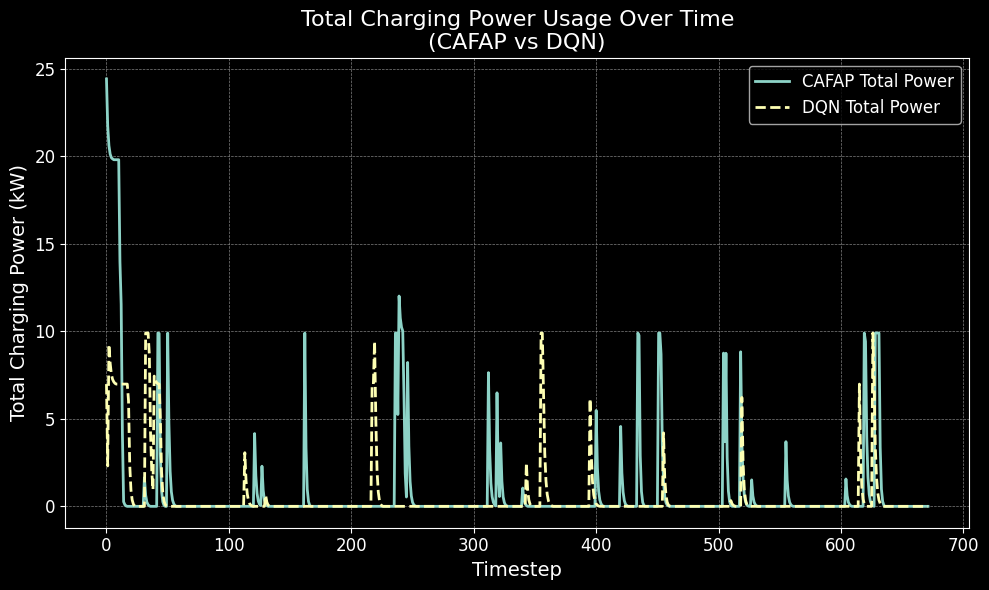

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming CAFAP_total_power and DQN_total_power are defined

timesteps = np.arange(CAFAP_total_power.shape[0])

plt.style.use('dark_background')  # <<< KEY: dark background

plt.figure(figsize=(10,6))

plt.plot(timesteps, CAFAP_total_power, label="CAFAP Total Power", linestyle="-", linewidth=2)
plt.plot(timesteps, DQN_total_power, label="DQN Total Power", linestyle="--", linewidth=2)

plt.xlabel("Timestep", fontsize=14)
plt.ylabel("Total Charging Power (kW)", fontsize=14)
plt.title("Total Charging Power Usage Over Time\n(CAFAP vs DQN)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

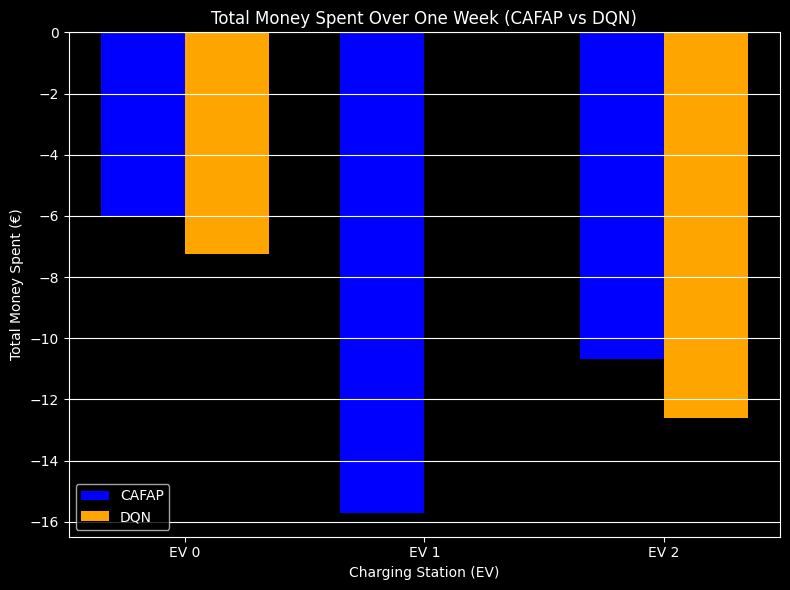

In [51]:
# Sum across timesteps
CAFAP_money_spent = np.sum(CAFAP_Stats.money_spent_at_each_step, axis=1)  # shape (3,)
DQN_money_spent = np.sum(DQN_Stats.money_spent_at_each_step, axis=1)      # shape (3,)

import numpy as np
import matplotlib.pyplot as plt

ev_ids = np.arange(len(CAFAP_money_spent))  # [0,1,2]

bar_width = 0.35

plt.figure(figsize=(8,6))

plt.bar(ev_ids - bar_width/2, CAFAP_money_spent, width=bar_width, label="CAFAP", color="blue")
plt.bar(ev_ids + bar_width/2, DQN_money_spent, width=bar_width, label="DQN", color="orange")

plt.xlabel("Charging Station (EV)")
plt.ylabel("Total Money Spent (€)")
plt.title("Total Money Spent Over One Week (CAFAP vs DQN)")
plt.xticks(ev_ids, [f"EV {i}" for i in ev_ids])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



In [52]:
CAFAP_money_spent  # shape (3,)
DQN_money_spent    # shape (3,)
total_cafap_spent = np.sum(CAFAP_money_spent)
total_dqn_spent = np.sum(DQN_money_spent)
# DQN is better if it spends *less* money
percent_savings = (total_cafap_spent - total_dqn_spent) / abs(total_cafap_spent) * 100

print(f"DQN reduces total cost by {percent_savings:.2f}% compared to CAFAP")


DQN reduces total cost by -38.79% compared to CAFAP


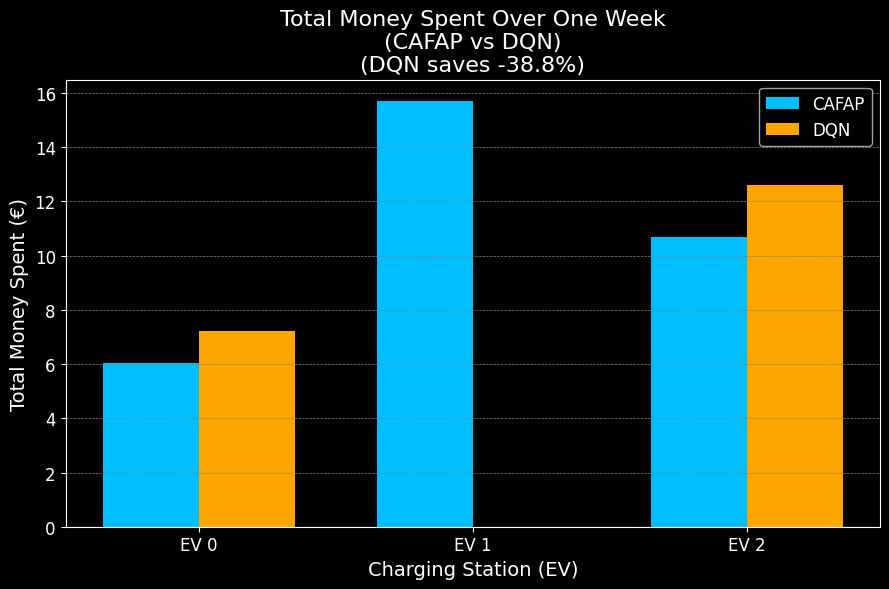

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming CAFAP_money_spent and PPO_money_spent are given

ev_ids = np.arange(len(CAFAP_money_spent))  # [0,1,2]
bar_width = 0.35

total_cafap_spent = np.sum(CAFAP_money_spent)
total_dqn_spent = np.sum(DQN_money_spent)
percent_savings = (total_cafap_spent - total_dqn_spent) / abs(total_cafap_spent) * 100

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(9,6))

bars1 = ax.bar(ev_ids - bar_width/2, -CAFAP_money_spent, width=bar_width, label="CAFAP", color="#00BFFF")  # deepskyblue
bars2 = ax.bar(ev_ids + bar_width/2, -DQN_money_spent, width=bar_width, label="DQN", color="#FFA500")      # orange

ax.axhline(0, color='white', linewidth=0.8)

ax.set_xlabel("Charging Station (EV)", fontsize=14)
ax.set_ylabel("Total Money Spent (€)", fontsize=14)
ax.set_title(f"Total Money Spent Over One Week\n(CAFAP vs DQN)\n(DQN saves {percent_savings:.1f}%)", fontsize=16)
ax.set_xticks(ev_ids)
ax.set_xticklabels([f"EV {i}" for i in ev_ids], fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
